# Recurrent Neural Networks

<img src='https://www.cs.colostate.edu/~anderson/cs545/notebooks/recurrent.png' width='600'>

In [87]:
import numpy as np
import optimizers_A4 as opt
import gzip
import pickle
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, clear_output

    N number of samples (in time)
    S  number of samples per sequence
    I number of components in each sample
    H number of units in hidden recurrent layer
    O number of units in linear output layer

    X:  N x S x I
    Vx: I x H   Vz: H x H    Vb: 1 x H
    Z:  N x S+1 X H
    Wz: H x 0   Wb: 1 x O
    Y:  N x O
    T:  N x O   only use times when T not nan for training

    Dy: N x O   Dz:  N x H
    Gvx:  N x I x H    Gvz:  N x H x H    Gvb:  N x H
    Gwz:  N x H x O    Gwb:  N x O

In [88]:
def make_indicator_variables(T):
    '''Assumes argument is N x 1, N samples each being integer class label.'''
    classes = np.unique(T).reshape(-1)
    # Make sure T is two-dimensional. Should be nSamples x 1.
    if T.ndim == 1:
        T = T.reshape((-1, 1))    
    return (T == classes).astype(float)  # to work on GPU

def softmax(Y):
    '''Apply to final layer weighted sum outputs'''
    # Trick to avoid overflow
    # maxY = max(0, self.max(Y))
    maxY = Y.max()  #self.max(Y))        
    expY = np.exp(Y - maxY)
    denom = expY.sum(1).reshape((-1, 1))
    Y = expY / (denom + sys.float_info.epsilon)
    return Y

In [89]:
def make_weights(I, H, O):
    n_weights = I * H + H * H + H + H * O + O
    all_weights = np.random.uniform(-1, 1, n_weights)

    first = 0
    last = first + I * H
    Vx = all_weights[first:last].reshape(I, H)
    Vx[:] /= np.sqrt(I + H + 1)
    first = last
    last = first + H * H
    Vz = all_weights[first:last].reshape(H, H)
    Vz[:] /= np.sqrt(I + H + 1)
    first = last
    last = first + H
    Vb = all_weights[first:last].reshape(1, H)
    Vb[:] /= np.sqrt(I + H + 1)

    first = last
    last = first + H * O
    Wz = all_weights[first:last].reshape(H, O)
    Wz[:] /= np.sqrt(H + 1)
    first = last
    last = first + O
    Wb = all_weights[first:last].reshape(1, O)
    Wb /= np.sqrt(H + 1)

    Ws = [Vx, Vz, Vb, Wz, Wb]

    return all_weights, Ws

In [90]:
# make these global
Z = None
Y = None

def forward(X, T):  # , Ws):

    global Z, Y

    N, S, I = X.shape
    _, O = T.shape
    _, H = Ws[0].shape

    Vx, Vz, Vb, Wz, Wb = Ws

    Z = np.zeros((N, S + 1, H))
    Y = np.zeros((N, O))

    XV = X @ Vx
    for n in range(N):
        for seq in range(S):
            Z[n, seq + 1 :] = np.tanh(XV[n, seq, :] + Z[n, seq, :] @ Vz + Vb)
    Y[:] = Z[:, -1, :] @ Wz + Wb

In [91]:
def error_f(X, Ti):  

    forward(X, Ti)
    Ysm = softmax(Y)
    return -np.mean(Ti * np.log(Ysm + sys.float_info.epsilon))

def gradient_f(X, Ti):

    N, S, I = X.shape
    _, O = Ti.shape
    _, H = Ws[0].shape

    Vx, Vz, Vb, Wz, Wb = Ws
    Gvx, Gvz, Gvb, Gwz, Gwb = Gs

    Ysm = softmax(Y)
    
    # Set Dy for nan targets to 0
    Dy = -2 * (Ti - Ysm)
    Gwz[:] = Z[:, -1, :].T @ Dy  # Z for last sample in sequence
    Gwb[:] = Dy.sum(0)

    # For each sample, BPTT to calculate gradient for that sample
    Dz = np.zeros((N, H))
    Gvx[:] = 0
    Gvz[:] = 0
    Gvb[:] = 0

    n_bptt_steps = 0
    for n in range(N):
        Dz = Dy[n:n+1, :] @ Wz.T
        for seq in range(S - 1, -1, -1):
            # Backprop Dz
            Dz = (Dz @ Vz.T * (1 - Z[n, seq:seq + 1, :]**2))
            Gvx += X[n:n + 1, seq, :].T @ Dz
            Gvz += Z[n:n + 1, seq, :].T @ Dz
            Gvb += Dz

    return all_gradients / S

In [92]:
def load_mnist():
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    Xtrain = train_set[0]
    Ttrain = train_set[1].reshape(-1, 1)
    Xval = valid_set[0]
    Tval = valid_set[1].reshape(-1, 1)
    Xtest = test_set[0]
    Ttest = test_set[1].reshape(-1, 1)
    Xtrain = np.vstack((Xtrain, Xval))
    Ttrain = np.vstack((Ttrain, Tval))
    return Xtrain, Ttrain, Xtest, Ttest

In [93]:
Xtrain, Ttrain, Xtest, Ttest = load_mnist()
Xtrain = Xtrain.reshape(-1, 28, 28)
Xtest = Xtest.reshape(-1, 28, 28)

In [94]:
def get_batch(X, T, batch_size=100):
    n_samples = X.shape[0]
    rows = np.arange(n_samples)
    np.random.shuffle(rows)
    X = X[rows]
    T = T[rows]
    for first in range(0, n_samples, batch_size):
        last = first + batch_size
        yield X[first:last], T[first:last]
    # should return last batch of n_samples not evenly divided by batch_size

In [95]:
# Xtrain = Xtrain[:10000, ...]
# Ttrain = Ttrain[:10000, ...]

In [96]:
N, S, I = Xtrain.shape
O = 10
H = 100

all_weights, Ws = make_weights(I, H, O)
all_gradients, Gs = make_weights(I, H, O)

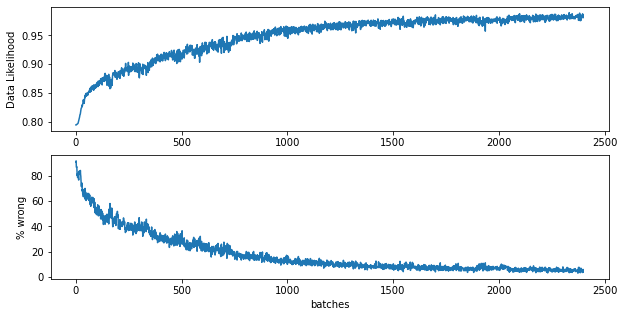

In [97]:
graphics = True

if graphics:
    fig = plt.figure(figsize=(10, 5))

rho = 0.001
n_epochs = 20
batch_size = 500

error_trace = []
percent_wrong = []
optimizer = opt.Adam(all_weights)
Ttraini = make_indicator_variables(Ttrain)

for epoch in range(n_epochs):
    for i, (X, Ti) in enumerate(get_batch(Xtrain, Ttraini, batch_size)):

        error = optimizer.step(error_f, gradient_f,
                               fargs=[X, Ti],
                               learning_rate=rho, momentum=0.9)
        
        error_trace.append(np.exp(-error))
        Yc = Y.argmax(1).reshape(-1, 1)
        Tc = Ti.argmax(1).reshape(-1, 1)
        percent = (sum(Yc != Tc)/len(Tc))[0]*100
        percent_wrong.append(percent)
        
        if graphics:
            fig.clf()
            plt.subplot(2, 1, 1)
            plt.plot(error_trace)
            plt.ylabel('Data Likelihood')
            plt.subplot(2, 1, 2)
            plt.plot(percent_wrong)
            plt.ylabel('% wrong')
            plt.xlabel('batches')
            clear_output(wait=True)
            display(fig)

    Yc = Y.argmax(1).reshape(-1, 1)
    Tc = Ti.argmax(1).reshape(-1, 1)
    print(f'Epoch {epoch+1} Batch {i+1} {error=:.2f} {percent:.2f} % incorrect')
    
if graphics:
    clear_output(wait=True)